Import Required Libraries

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Load Dataset

In [26]:
df = pd.read_csv("/content/drive/MyDrive/House_Rent_Dataset.csv")
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


Basic Inspection

In [27]:
df.shape
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


,0
Posted On,0
BHK,0
Rent,0
Size,0
Floor,0
Area Type,0
Area Locality,0
City,0
Furnishing Status,0
Tenant Preferred,0


Drop Clearly Useless Columns

In [28]:
df.drop(['Posted On', 'Area Locality', 'Point of Contact'], axis=1, inplace=True)

Floor Column Cleaning

In [29]:
def extract_floor_values(floor):
    try:
        floor = floor.lower().strip()

        if "ground" in floor:
            current = 0
            total = int(floor.split("out of")[1])
        elif "lower basement" in floor:
            current = -1
            total = int(floor.split("out of")[1])
        elif "upper basement" in floor:
            current = -1
            total = int(floor.split("out of")[1])
        else:
            current, total = floor.split("out of")
            current = int(current.strip())
            total = int(total.strip())

        return pd.Series([current, total])

    except:
        return pd.Series([np.nan, np.nan])


df[['Current_Floor', 'Total_Floors']] = df['Floor'].apply(extract_floor_values)
df.drop('Floor', axis=1, inplace=True)

Handle Missing Floor Values

In [30]:
df['Current_Floor'].fillna(df['Current_Floor'].median(), inplace=True)
df['Total_Floors'].fillna(df['Total_Floors'].median(), inplace=True)

df[['Current_Floor','Total_Floors']] = df[['Current_Floor','Total_Floors']].astype(int)

/tmp/ipython-input-197962191.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Current_Floor'].fillna(df['Current_Floor'].median(), inplace=True)
/tmp/ipython-input-197962191.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

Encode Categorical Variables (One-Hot)

In [31]:
cat_cols = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred']

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

Target Transformation

In [32]:
df['Rent_log'] = np.log1p(df['Rent'])

Correlation Check & Feature Decision

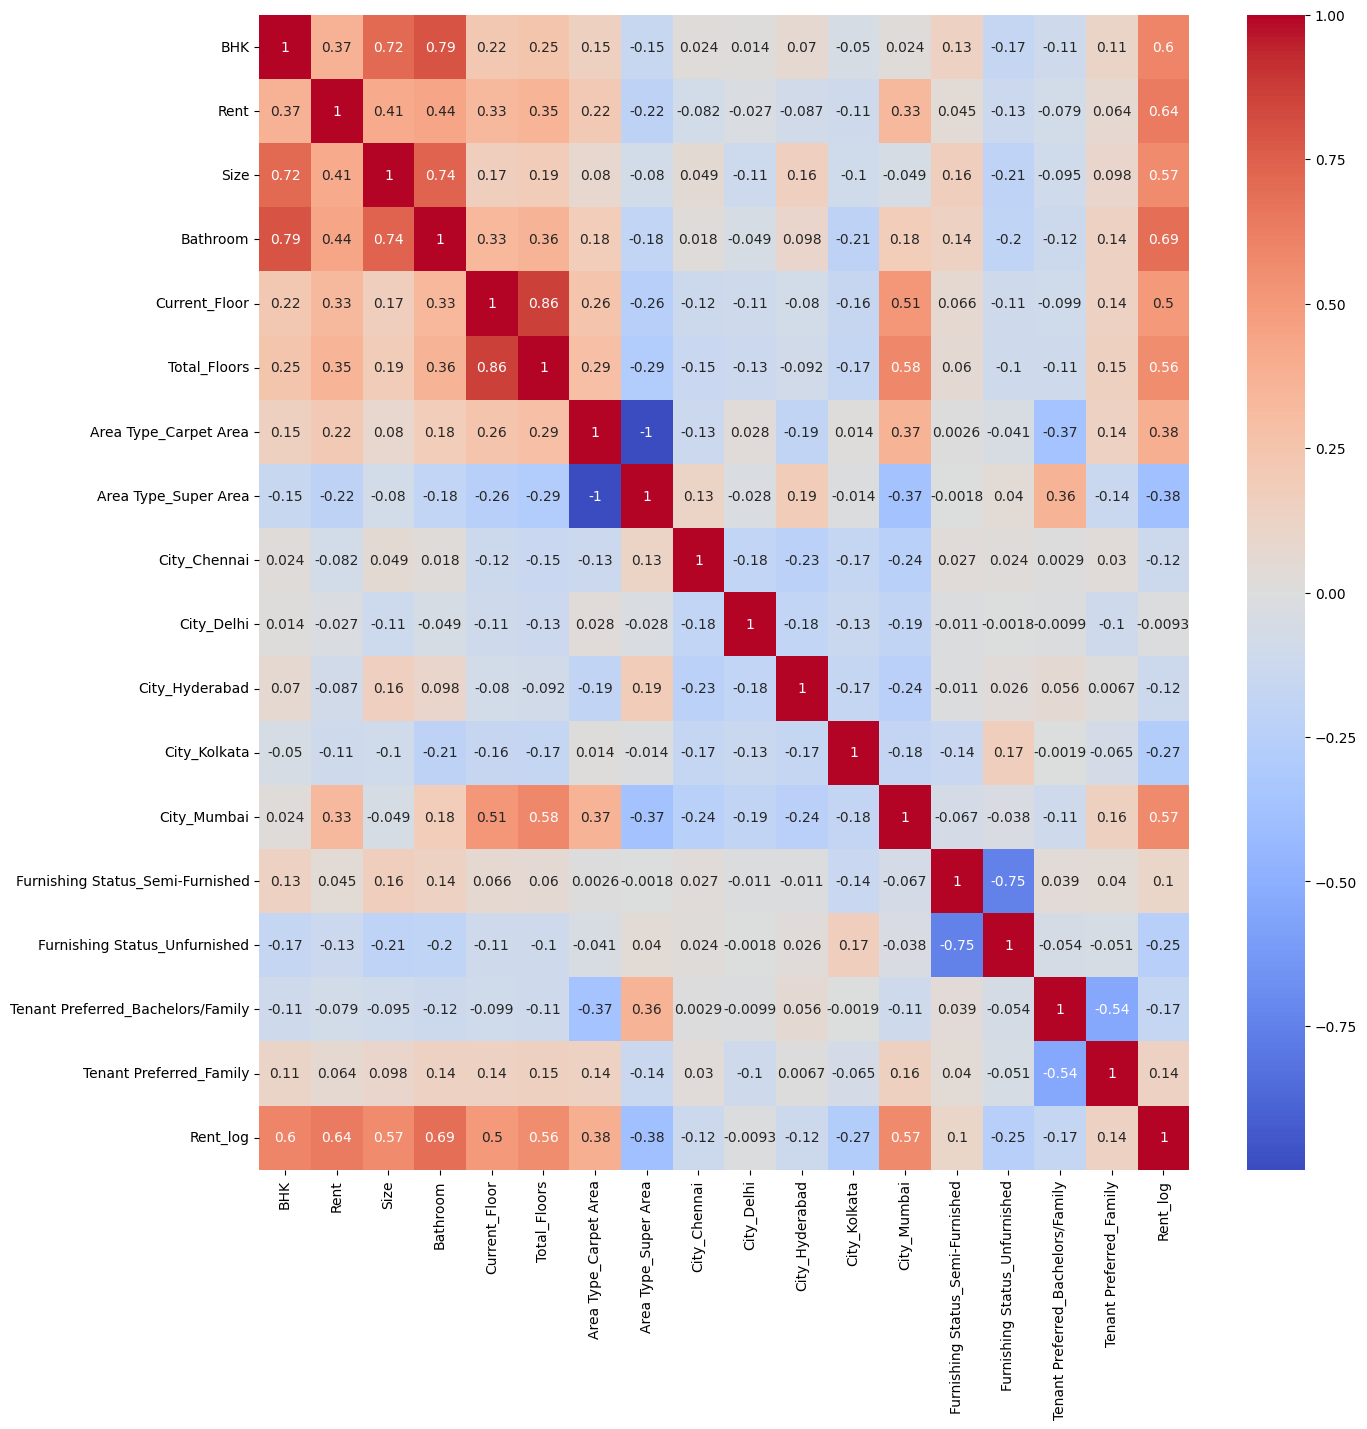

In [33]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), cmap='coolwarm',annot=True)
plt.show()

In [34]:
df.drop('Current_Floor', axis=1, inplace=True)

In [35]:
Q1 = df["Rent"].quantile(0.25)
Q3 = df["Rent"].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df = df[(df["Rent"] >= lower_limit) & (df["Rent"] <= upper_limit)]

print("Dataset shape after outlier removal:", df.shape)

Dataset shape after outlier removal: (4226, 17)


Feature–Target Split

In [36]:
X = df.drop(['Rent', 'Rent_log'], axis=1)
y = df['Rent_log']

Train–Test Split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Scaling

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Models

In [40]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [41]:
results = {}

for name, model in models.items():
    if name in ["Linear Regression", "Ridge Regression", "Lasso Regression"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "RMSE": rmse,
        "R2_Score": r2,
        "CV_R2_Mean": scores.mean()
    }
    print(f"{name} --> RMSE: {rmse:.4f}, R2: {r2:.4f}, CV R2: {scores.mean():.4f}")


Linear Regression --> RMSE: 0.3629, R2: 0.7104, CV R2: 0.6807
Ridge Regression --> RMSE: 0.3629, R2: 0.7104, CV R2: 0.6808
Lasso Regression --> RMSE: 0.4428, R2: 0.5690, CV R2: 0.5531
Random Forest --> RMSE: 0.3606, R2: 0.7142, CV R2: 0.6728
Gradient Boosting --> RMSE: 0.3484, R2: 0.7330, CV R2: 0.7097
XGBoost --> RMSE: 0.3475, R2: 0.7345, CV R2: 0.7029


Final Best Model Prediction

In [57]:
results_df = pd.DataFrame(results).T.sort_values(by="R2_Score", ascending=False)
print("\nModel Comparison:\n", results_df)


Model Comparison:
                        RMSE  R2_Score  CV_R2_Mean
XGBoost            0.347510  0.734472    0.702914
Gradient Boosting  0.348443  0.733045    0.709710
Random Forest      0.360560  0.714155    0.672754
Ridge Regression   0.362913  0.710412    0.680751
Linear Regression  0.362925  0.710394    0.680749
Lasso Regression   0.442764  0.568958    0.553148


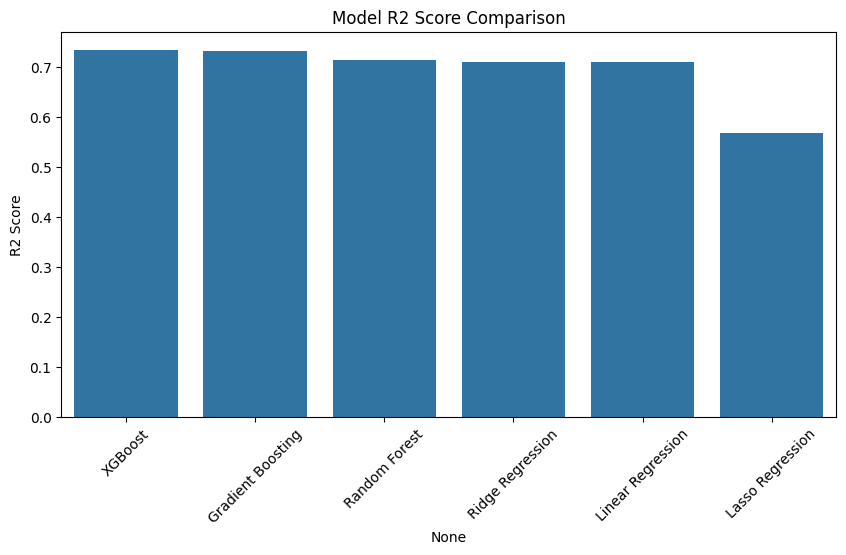

In [44]:
plt.figure(figsize=(10,5))
sns.barplot(x=results_df.index, y=results_df['R2_Score'])
plt.xticks(rotation=45)
plt.title("Model R2 Score Comparison")
plt.ylabel("R2 Score")
plt.show()

Best Model: XGBoost


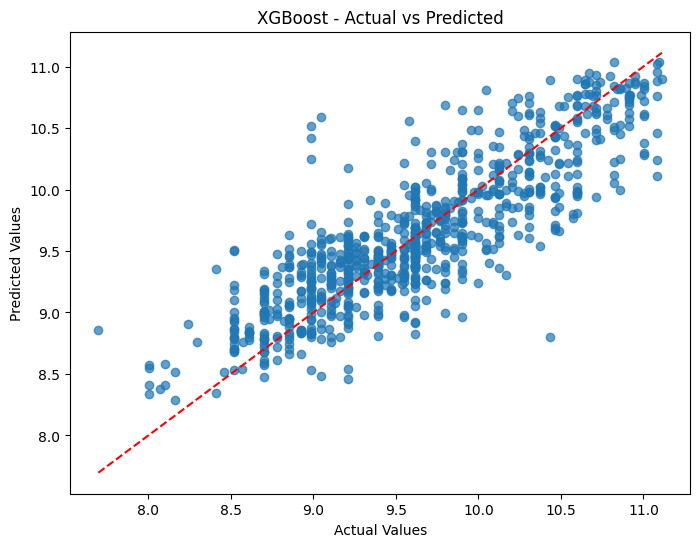

In [54]:
best_model_name = results_df.index[0]
print(f"Best Model: {best_model_name}")

best_model = models[best_model_name]

if best_model_name in ["Linear Regression", "Ridge Regression", "Lasso Regression"]:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"{best_model_name} - Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

Save the Best Model

In [ ]:
joblib.dump(best_model, "best_model.pkl")
print(f"{best_model_name} saved as best_model.pkl")